# 분류

분류(Classification) 알고리즘은 예측하려는 대상의 속성(독립 변수)을 입력 받고, 목표 변수가 갖고 있는 카테고리(범주형) 값 중에서 어느 한 값으로 분류하여 예측한다. 아래 그림과 같이 훈련 데이터에 목표 변수 값(0 또는 1)을 함께 입력하기 때문에 지도 학습 유형에 속하는 알고리즘이다.

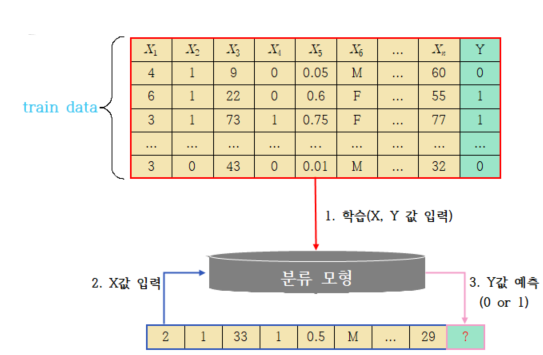

이 모형은 고객 분류, 질병 진단, 스팸 메일 필터링, 음성 인식 등 목표 변수가 카테고리 값을 갖는 경우에 사용된다. KNN, SVM, Decision Tree, Logistic Regression 등 다양한 알고리즘이 존재한다.

* KNN

KNN은 k-Nearest-Neighbors의 약칭이다. k개의 가까운 이웃이라는 뜻이다. 새로운 관측값이 주어지면 기존 데이터 중에서 가장 속성이 비슷한 k개의 이웃을 먼저 찾는다. 그리고 가까운 이웃들이 갖고 있는 목표 값과 같은 값으로 분류하여 예측한다.

한편 k값에 따라 예측의 정확도가 달라지므로, 적절한 k값을 찾는 것이 매우 중요하다. 

#### Step 1 - 데이터 준비

Seaborn 라이브러리에서 'titanic' 데이터셋을 가져와서 변수 df에 저장한다. 


In [1]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### Step 2 - 데이터 탐색

info() 메소드로 데이터의 자료형과 개수를 확인한 결과 'age', 'embarked', 'deck' 등 일부 열에 누락 데이터가 포함되어 있다. 데이터의 특성과 분석 목표에 맞춰 누락 데이터를 처리한다.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


객실 데크 위치를 나타내는 'deck' 열에는 유효한 값이 203개밖에 없다. 688개의 누락 데이터가 있다는 것인데, 전체 891명의 승객 중에서 688명의 데이터가 존재하지 않는다는 뜻이다. 따라서 'deck' 열을 제거하자.

그리고 승선도시를 나타내는 'embark_town' 열은 'embarked' 열과 동일한 의미를 갖기 때문에 중복을 없애기 위해 열 자체를 제거하자.

1. 'deck'열과 'embark_town' 열 제거

In [3]:
rdf = df.drop(['deck', 'embark_town'], axis=1)
rdf.columns.values

array(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'alive', 'alone'],
      dtype=object)

승객의 나이를 나타내는 'age'열에는 누락 데이터가 177개 포함되어 있다.

분석에 포함시켜야하는 중요한 속성으로 판단될 경우 예측 결과에 영향을 최소화하는 방법을 선택해야 한다. 평균 나이로 치환하는 방법도 가능하지만 누락 데이터가 있는 행을 모두 제거하자.

즉, 177명의 승객 데이터를 포기하고 남아있는 714명의 승객만을 분석 대상으로 한다.

In [4]:
# how (default='any') : 하나 이상의 NaN 또는 모든 NaN이 있을 때 DataFrame에서 행 또는 열이 제거되는지 확인
# 'any' : NaN값이 있으면 해당 행이나 열을 삭제
# 'all' : 모든 값이 NaN이면 해당 행이나 열을 삭제
rdf.dropna(subset=['age'], how='any', axis=0, inplace=True)
len(rdf)

714

'embarked' 열에는 승객들이 타이타익호에 탑승한 도시명의 첫 글자가 들어 있다. 누락 데이터가 2개에 불과하므로 탑승한 승객이 가장 많은 도시명으로 치환한다.



In [5]:
# embarked 열의 NaN값을 승선 도시 중 가장 많이 출현한 값으로 치환
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
print(most_freq)
print()
print(rdf.describe(include='all'))

#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

display(rdf['embarked'].fillna(most_freq, inplace=True))

S

          survived      pclass   sex         age  ...  who  adult_male  alive alone
count   714.000000  714.000000   714  714.000000  ...  714         714    714   714
unique         NaN         NaN     2         NaN  ...    3           2      2     2
top            NaN         NaN  male         NaN  ...  man        True     no  True
freq           NaN         NaN   453         NaN  ...  413         413    424   404
mean      0.406162    2.236695   NaN   29.699118  ...  NaN         NaN    NaN   NaN
std       0.491460    0.838250   NaN   14.526497  ...  NaN         NaN    NaN   NaN
min       0.000000    1.000000   NaN    0.420000  ...  NaN         NaN    NaN   NaN
25%       0.000000    1.000000   NaN   20.125000  ...  NaN         NaN    NaN   NaN
50%       0.000000    2.000000   NaN   28.000000  ...  NaN         NaN    NaN   NaN
75%       1.000000    3.000000   NaN   38.000000  ...  NaN         NaN    NaN   NaN
max       1.000000    3.000000   NaN   80.000000  ...  NaN         NaN   

None

value_counts() 메소드와 idxmax() 메소드를 사용하여 승객이 가장 많은 탑승한 도시명의 첫 글자가 's'라는 것을 알 수 있다. describe(include='all') 메소드로 'embarked' 열의 최빈값(top)을 확인해도 같은 결과를 얻는다. 그리고 'embarked'열에 fillna() 메소드를 사용하여 누락 데이터를 's' 값으로 바꾼다.

#### Step 3 - 속성 선택

변수로 사용할 후보 열을 선택한다. 예측 변수로 생존 여부를 나타내는 'survived' 열을 추가하고, 독립 변수로 사용할 후보 열을 6개 포함한다.

In [6]:
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


KNN 모형에 적용하기 위해 'sex'열과 'embarked' 열의 범주형 데이터를 숫자형으로 변환한다. 이 과정을 더미 변수를 만든다고 하고 원핫인코딩(one-hot-encoding)이라고도 부른다.

'sex'열의 'female'값과 'male'값을 열 이름으로 갖는 2개의 더미 변수 열이 만들어진다. 'embarked' 열은 3개의 더미 변수 열이 만들어지는데, prefix='town' 옵션을 사용하여 열 이름에 접두어 'town'을 붙인다. concat() 함수로 생성된 더미 변수 열을 기존 데이터프레임에 연결하고 'sex'열과 'embarked'열은 삭제한다.

In [7]:
onehot_sex = pd.get_dummies(ndf['sex'])
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_sex], axis=1)
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


#### Step 4 - 훈련/검증 데이터 분할

Step 3에서 정리한 열 중에서 예측 변수인 'survived' 열을 변수 y에 저장하고, 나머지 열들을 독립 변수로 사용하기 위하여 변수 X에 할당한다. 그리고 독립 변수 열들이 갖는 데이터의 상대적 크기 차이를 없애기 위해 정규화 과정을 거친다.

정규화 -> 이때 sklearn의 preprocessing 모듈을 사용한다.

In [8]:
# 속성(변수) 선택
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']] # 독립 변수
y = ndf['survived'] # 예측(종속) 변수

# 독립 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)




---


##### 분류 모형의 예측력을 평가하는 지표

- Confusion Matrix

모형이 예측하는 값에는 두 가지(True/False)가 있고, 각 예측값은 실제로 True이거나 False일 수 있다. 아래 그림과 같이 모형의 예측값과 실제 값을 각각 축으로 하는 2 X 2 매트릭스로 표현한 것을 Confusion Matrix라고 한다.

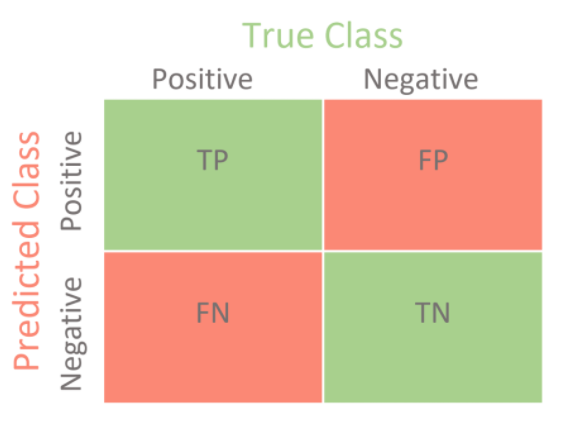

- 정확도(Precision)

True로 예측한 분석대상 중에서 실제값이 True인 비율 -> 정확성, 정확도가 높다는 것은 False Positive(실제 False를 True로 잘못 예측) 오류가 작다는 뜻.

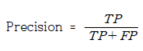


- 재현율(Recall)

실제 값이 True인 분석대상 중에서 True로 예측 -> 적중한 비율, 모형의 완전성을 나타냄. 재현율이 높다는 것은 False Negative(실제 True를 False로 잘못 예측) 오류가 낮다는 뜻이다.

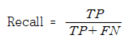

- F1 지표(F1-score)

정확도와 재현율이 균등하게 반영될 수 있도록 정확도와 재현율의 조화 평균을 계산한 값으로, 모형의 예측력을 종합적으로 평가하는 지표. 값이 높을수록 분류 모형의 예측력이 좋다고 할 수 있음

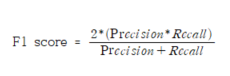


---




#### Step 5 - 모형 학습 및 검증

sklearn 라이브러리의 neighbors 모듈을 사용한다. KNeighborsClassifier() 함수로 KNN 분류 모형 객체를 생성하여 변수 knn에 저장한다. 

n_neighbors=5와 같이 이웃의 숫자를 5개로 설정하고 훈련 데이터(X_train, y_train)를 fit() 메소드에 입력하여 모형 학습.

검증 데이터(X_test)를 predict() 메소드에 전달하여 모형이 분류한 예측값을 변수 y_hat에 저장.

이 값을 실제 값인 y_test와 비교

In [9]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류)
y_hat = knn.predict(X_test)

print(y_hat[:10])
print(y_test.values[:10])

[0 0 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


모형의 예측 능력 평가

metrics 모듈의 confusion_matrix() 함수를 사용하여 Confusion Matrix를 계산한다. 이 함수는 [[TN, FP], [FN, TP]] 형태로 반환한다.

In [10]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics
knn_matrix = metrics.confusion_matrix(y_test, y_hat)
print(knn_matrix)

[[109  16]
 [ 25  65]]


215명의 승객 중에서 미생존자를 정확히 예측한 TN은 109명.

미생존자를 생존자로 잘 못 분류한 FP는 16명.
 
생존자를 미생존자로 잘못 분류한 FN은 25명.

생존자를 정확하게 예측한 TP는 65명으로 확인.

모형의 예측 능력을 평가하는 지표를 계산

metrics 모듈의 classification_report() 함수를 사용하면 precision, recall, f1-score 지표를 출력한다.

In [11]:
# 모형 성능 평가 - 평가 지표 계산
knn_report = metrics.classification_report(y_test, y_hat)
print(knn_report)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       125
           1       0.80      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215



f1-score 지표를 보면 미생존자(0) 예측의 정확도가 0.84.

생존자(1) 예측의 정확도는 0.76으로 예측 능력에 차이가 있음.